In [1]:
#Esto es solamente para que Jupyter pueda encontrar las librerías necesarias
import sys
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\python37.zip')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\DLLs')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\lib')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\lib\\site-packages')

In [2]:
from scipy import random
from statistics import mean
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt
import itertools
import getdist
import pandas as pd
import constants
import distance

In [3]:
def lnL(model, data, sigmaT, theory, theta):
    return -0.5 * np.sum(((theory - model(data, theta)))**2/sigmaT**2)

def prior(model, sigmaT, theory, theta):
    totalSum = 0
    p = np.zeros(2)
    inf = [theory[0] - 3, theory[1] - 3]
    sup = [theory[0] + 3, theory[1] + 3]
    
    for i in range(2):
        if inf[i] < theta[i] < sup[i]:
            p[i] = -1 * np.log(sup[i] - inf[i])
        else:
            p[i] = 0
    
    return sum(p)
    
#def monteCarloN(model, data, sigmaT, sigmaP, theory, p0, chains, likelihood):
def monteCarloN(model, data, sigmaT, sigmaP, theory, p0, chains, prior, likelihood):
    
    np.random.seed(500)
    acceptance = np.zeros(chains)
    chainList = []
        
    for i in range(0, chains):
        
        chain = []
        #L0 -> lnPost
        #lnPost = (likelihood(model, data, sigmaT, theory, p0[i]) + prior(model, sigmaT, theory, p0[i]))
        lnPost = likelihood(model, data, sigmaT, theory, p0[i]) + prior(model, sigmaT, theory, p0[i])
        chain.append([p0[i], lnPost])

        for j in range(0, NMAX):
            
            newp = []
            
            for index, value in enumerate(p0[i]): newp.append(sigmaP[index] * np.random.randn() + value)   
                
            newL = likelihood(model, data, sigmaT, theory, newp) + prior(model, sigmaT, theory, newp)

            if(newL > lnPost):
                chain.append([newp, newL])
                p0[i] = newp
                lnPost = newL
                acceptance[i] += 1
                
            elif(newL - lnPost > np.random.randn()): 
                chain.append([newp, newL])
                acceptance[i] += 1

            else: chain.append([newp, newL])
                
        chainList.append(chain)
            
    return [chainList, acceptance]
            
def line(x, theta):
    return theta[0]*x + theta[1]

In [4]:
def si2(chain, mean):
    totalSum = 0
    for i in chain: totalSum += (np.asarray(chain) - mean)**2
    return 1/(NMAX - 1) * totalSum

def Bn(chainList, mu):
    totalSum = 0
    for chain in chainList: totalSum += (mean(chain) - mu)**2
    return 1/(chains - 1) * totalSum

In [5]:
dataFrame = pd.read_csv("SNData/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb")
data = np.array(pd.read_csv("SNData/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb"))
dataFrame

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,06D3en,1.060801,1.060000,0,24.707870,0.132013,-0.952679,0.412773,-0.158207,0.061030,...,0.935000,53881.407872,0.949506,0.010444,-0.003050,0.004456,1,215.305567,52.456079,-0.036389
242,Gabi,1.120850,1.120000,0,25.147113,0.121686,0.620453,0.307485,-0.075491,0.053200,...,0.296000,53488.738514,0.524573,0.004032,0.000388,0.005988,4,189.057630,62.202100,0.000000
243,Lancaster,1.230892,1.230000,0,26.046776,0.128558,-0.077374,0.690464,0.087011,0.048271,...,0.194500,53431.841687,1.597837,0.003542,0.000211,0.008241,4,189.236330,62.214814,0.000000
614,Torngasek,1.265901,1.265000,0,25.735598,0.128614,0.286816,0.559546,0.021062,0.047718,...,0.391000,52693.622067,1.790259,-0.003817,-0.000169,0.003064,4,189.331960,62.310417,0.000000


In [6]:
v0 = np.loadtxt('SNData/jla_v0_covmatrix.dat')
v0 = np.reshape(v0, (740, 740))

v0a = np.loadtxt('SNData/jla_v0a_covmatrix.dat')
v0a = np.reshape(v0a, (740, 740))

v0b = np.loadtxt('SNData/jla_v0b_covmatrix.dat')
v0b = np.reshape(v0b, (740, 740))

va = np.loadtxt('SNData/jla_va_covmatrix.dat')
va = np.reshape(va, (740, 740))

vab = np.loadtxt('SNData/jla_vab_covmatrix.dat')
vab = np.reshape(vab, (740, 740))

vb = np.loadtxt('SNData/jla_vb_covmatrix.dat')
vb = np.reshape(vb, (740, 740))

In [7]:
sumTotal = v0 + v0a + v0b + va + vab + vb

In [8]:
values = [0.14, 3.1, -19.05, 0.5]

def muP(df):
    return np.array(df.mb) - (values[2] - values[0] * np.array(df.x1) + values[1] * np.array(df.color))

def muT(df):
    pointer = {'omega_M_0':values[3], 'omega_lambda_0':1-values[3], 'omega_k_0':0.0, 'h':0.7}
    return 5*np.log10(distance.luminosity_distance(np.array(df.zcmb), **pointer)*1e6/10)

mup = muP(dataFrame)
mut = muT(dataFrame)
z = np.array(dataFrame.zcmb)

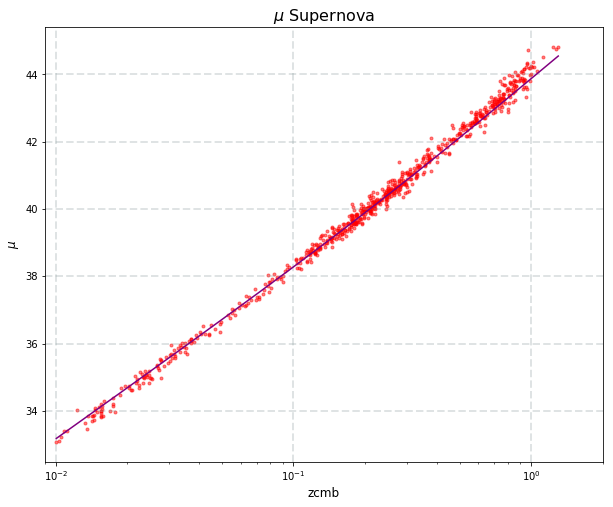

In [9]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.scatter(z, mup, marker = '.', color = 'red', alpha = 0.5)
plt.plot(z, mut, color = 'purple')

plt.title('$\mu$ Supernova', fontsize = 16)
#plt.legend(title = 'Ajuste', loc = 'upper left', fontsize = 12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.3)
plt.xlabel('zcmb', fontsize = 12)
plt.ylabel('$\mu$', fontsize = 12)

plt.xscale('log')
plt.xlim(0.009, 2)
plt.show()

In [10]:
def line(x, theta):
    return theta[0]*x + theta[1]

#def novaModel(data, theta):
#    return theta[4] - (data[2] - data[0] * theta[6] + data[1] * theta[8])

def novaModel(data, theta):
    return data[4] - (theta[2] - theta[0] * data[6] + theta[1] * data[8])

In [11]:
def novaPrior(model, sigmaT, theory, theta):
    totalSum = 0
    p = np.zeros(4)
    inf = [-3, 0, -22, 0]
    sup = [3, 6, -16, 1]
    
    for i in range(len(theta)):
        if inf[i] < theta[i] < sup[i]:
            p[i] = -1 * np.log(sup[i] - inf[i])
        else:
            p[i] = 0
    
    return sum(p)

def novaLikelihood(model, data, sigmaT, theory, theta):
    theory = muT(dataFrame)
    return -0.5 * np.sum(((theory - model(data, theta)))**2/sigmaT**2)

In [12]:
NMAX = 10000
burn = int(0.1*NMAX)
size = 740
chains = 8
valuesT = [0.14, 3.1, -19.5, 0.5]
x = mup
y = mut
#y = [line[4] - (valuesT[2] - valuesT[0] * line[6] + valuesT[1] * line[8]) for line in data]
sigmaP = [0.2, 0.2, 0.2, 0.2]#try changing it back to 0.1 after this try
sigmaT = 0.2 * np.ones(size)
#p0 = [[-5, 5, -12.5], [-3, 10, -11], [6.5, -9, -4], [1, -11, -22]]
#p0 = [[-2, 5, -15.5], [-3, 0.5, -22], [2.5, 1.5, -20], [1, -0.5, -17]]

p0 = [[0.16, 3.36, -19.05, 0.29],
      [0.12, 2.48, -19.10, 0.26],
      [0.13, 2.92, -19.22, 0.24], 
      [0.14, 2.52, -19.01, 0.22],
      [0.15, 3.01, -19.15, 0.23],
      [0.11, 3.15, -18.96, 0.27],
      [0.18, 2.73, -19.34, 0.21],
      [0.17, 3.50, -19.55, 0.25]]


chainList = monteCarloN(model = novaModel, data = x, sigmaT = sigmaT, sigmaP = sigmaP, 
                        theory = y, p0 = p0, chains = chains, prior = novaPrior, likelihood = novaLikelihood)

xdotsList, ydotsList, zdotsList, odotsList = [], [], [], []
fullDataSet = []

#Acomodo del resultado del MCMC en arreglos correspondientes
for chain in chainList[0]:
    dots, likelihoods = [], []
    xdots, ydots, zdots, odots = [], [], [], []

    for i in range(0, len(chain)):
        dots.append(chain[i][0])
        likelihoods.append(chain[i][1])

    for i in range(0, len(dots)):
        xdots.append(dots[i][0])
        ydots.append(dots[i][1])
        zdots.append(dots[i][2])
        odots.append(dots[i][3])
        
    fullDataSet.append(dots[burn:])    
    xdotsList.append(xdots)
    ydotsList.append(ydots)
    zdotsList.append(zdots)
    odotsList.append(odots)
    
#Se elije índice del mejor par de valores
bestIndex = likelihoods.index(max(likelihoods))

Mejores Valores:
Cadena 1:
	 α = 1.562457245021819	 β = 2.193164989484793	 M_{b} = -19.157343121514256	 $\Omega$ = 1.2999670045420955
	 Fracción de Aceptación: 0.0023
Cadena 2:
	 α = 0.6779059146749004	 β = 0.9525991279759318	 M_{b} = -19.229681492440907	 $\Omega$ = -0.143029227953553
	 Fracción de Aceptación: 0.0019
Cadena 3:
	 α = 0.29837071351694466	 β = 0.9581469087967343	 M_{b} = -19.056485624547392	 $\Omega$ = 1.7659734622231107
	 Fracción de Aceptación: 0.0028
Cadena 4:
	 α = 1.0745527292900465	 β = 1.039527945940677	 M_{b} = -19.75099226234683	 $\Omega$ = -0.3776468800890448
	 Fracción de Aceptación: 0.0024
Cadena 5:
	 α = 1.7721275884370218	 β = 2.249500194538419	 M_{b} = -18.3668612308649	 $\Omega$ = -0.44980852236346636
	 Fracción de Aceptación: 0.0021
Cadena 6:
	 α = 1.9030779848623753	 β = 2.443928900527429	 M_{b} = -19.73545654186707	 $\Omega$ = 2.440699103132468
	 Fracción de Aceptación: 0.0023
Cadena 7:
	 α = 0.3377934805542258	 β = 1.1667897581835862	 M_{b} = -19.48572

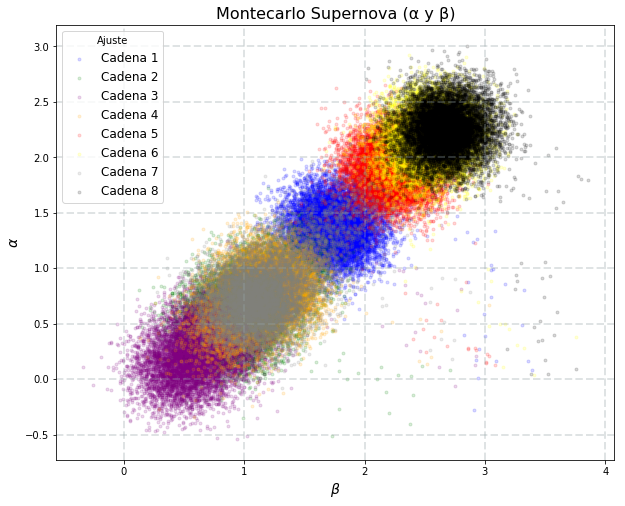

In [14]:
colors = ['blue', 'green', 'purple', 'orange', 'red', 'yellow', 'gray', 'black']

fig, ax0 = plt.subplots(figsize=(10, 8))

for i in range(0, len(chainList[0])):
    plt.scatter(ydotsList[i], xdotsList[i], color = colors[i], alpha = 0.15, marker = '.',  label = 'Cadena ' + str(i + 1))
    
plt.xlabel('$β$', fontsize = 14)
plt.ylabel('$α$', fontsize = 14)
plt.title('Montecarlo Supernova (α y β)', fontsize = 16)
plt.legend(title = 'Ajuste', loc = 'upper left', fontsize = 12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.3)


print('Mejores Valores:')
for i in range(0, chains):
    print('Cadena ' + str(i + 1) + ':')
    print('\t α = ' + str(xdotsList[i][bestIndex]) + '\t β = ' + str(ydotsList[i][bestIndex]) + '\t M_{b} = ' + str(zdotsList[i][bestIndex]) + '\t $\Omega$ = '  + str(odotsList[i][bestIndex]))
    
    print('\t Fracción de Aceptación: ' + str(chainList[1][i]/NMAX))

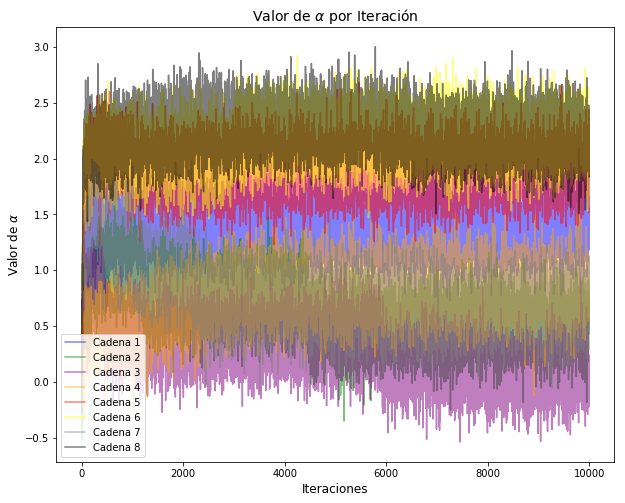

In [15]:
iterations = list(range(0, NMAX + 1))

fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $α$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $α$ por Iteración', fontsize = 14)

for i in range(0, len(chainList[0])):
    plt.plot(iterations, xdotsList[i], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

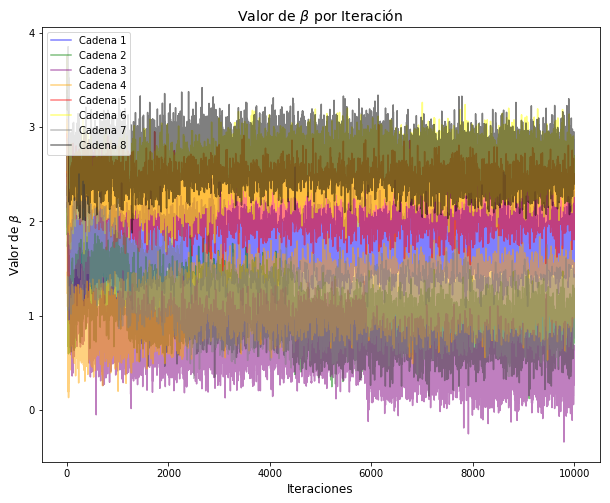

In [16]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $β$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $β$ por Iteración', fontsize = 14)

for i in range(0, len(chainList[0])):
    plt.plot(iterations, ydotsList[i], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

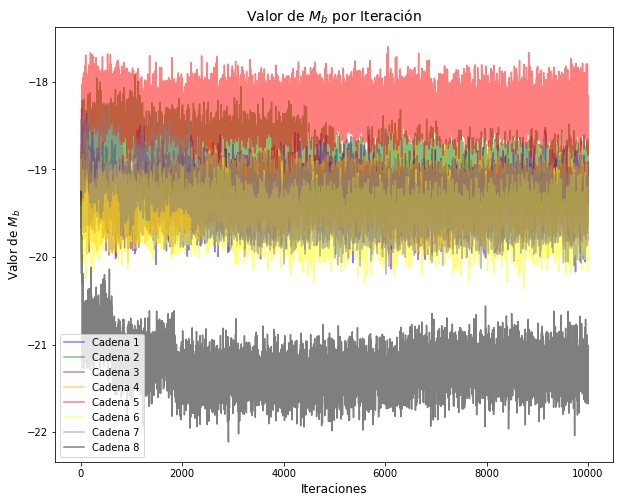

In [17]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $M_{b}$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $M_{b}$ por Iteración', fontsize = 14)

for i in range(0, len(chainList[0])):
    plt.plot(iterations, zdotsList[i], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

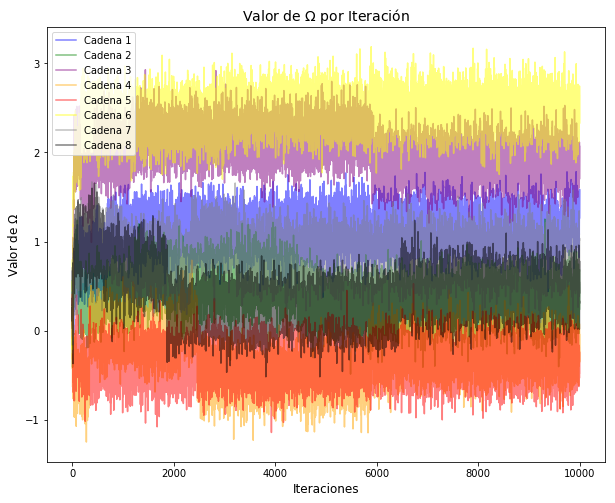

In [18]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $\Omega$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $\Omega$ por Iteración', fontsize = 14)

for i in range(0, len(chainList[0])):
    plt.plot(iterations, odotsList[i], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

In [19]:
a_si2Values, b_si2Values, m_si2Values, o_si2Values = [], [], [], []
aBurned, bBurned, mBurned, oBurned =  [], [], [], []

for i in range(chains):
    aBurned.append(xdotsList[i][burn:])
    bBurned.append(ydotsList[i][burn:])
    mBurned.append(zdotsList[i][burn:])
    oBurned.append(odotsList[i][burn:])
    
for chain in range(chains):
    a_si2Values.append(si2(aBurned[i], mean(aBurned[i])))
    b_si2Values.append(si2(bBurned[i], mean(bBurned[i])))
    m_si2Values.append(si2(mBurned[i], mean(mBurned[i])))
    o_si2Values.append(si2(oBurned[i], mean(oBurned[i])))
    
a_s2 = np.sum(np.asarray(a_si2Values)**2)/chains
b_s2 = np.sum(np.asarray(b_si2Values)**2)/chains
m_s2 = np.sum(np.asarray(m_si2Values)**2)/chains
o_s2 = np.sum(np.asarray(o_si2Values)**2)/chains

print(f'Se obtuvo s^2 = {a_s2:.4f} para α, s^2 = {b_s2:.4f} para β, s^2 = {m_s2:.4f} para m, y s^2 = {o_s2:.4f} para Omega, teniendo 4 cadenas y descartando los primeros {burn} datos de un total de {NMAX}.')

Se obtuvo s^2 = 37.1871 para α, s^2 = 38.7110 para β, s^2 = 43.0407 para m, y s^2 = 85.9013 para Omega, teniendo 4 cadenas y descartando los primeros 1000 datos de un total de 10000.


In [20]:
a_mu = mean(list(itertools.chain.from_iterable(aBurned)))
b_mu = mean(list(itertools.chain.from_iterable(bBurned)))
m_mu = mean(list(itertools.chain.from_iterable(mBurned)))
o_mu = mean(list(itertools.chain.from_iterable(oBurned)))

a_sigmaHat = (NMAX - 1)/NMAX * a_s2 + Bn(mBurned, a_mu)
b_sigmaHat = (NMAX - 1)/NMAX * b_s2 + Bn(bBurned, b_mu)
m_sigmaHat = (NMAX - 1)/NMAX * m_s2 + Bn(mBurned, m_mu)
o_sigmaHat = (NMAX - 1)/NMAX * o_s2 + Bn(oBurned, o_mu)

aR = np.sqrt(a_sigmaHat/a_s2)
bR = np.sqrt(b_sigmaHat/b_s2)
mR = np.sqrt(m_sigmaHat/m_s2)
oR = np.sqrt(o_sigmaHat/o_s2)

print(f'Se obtuvieron: \nR = {aR} para α \nR = {bR} para β \nR = {mR} para M_b \nR = {oR} para Omega')

Se obtuvieron: 
R = 3.7670020351985998 para α 
R = 1.0077811862774506 para β 
R = 1.008286940016188 para M_b 
R = 1.0059746936863925 para Omega


In [21]:
fullDataSet = list(itertools.chain.from_iterable(fullDataSet))

Removed no burn in


C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

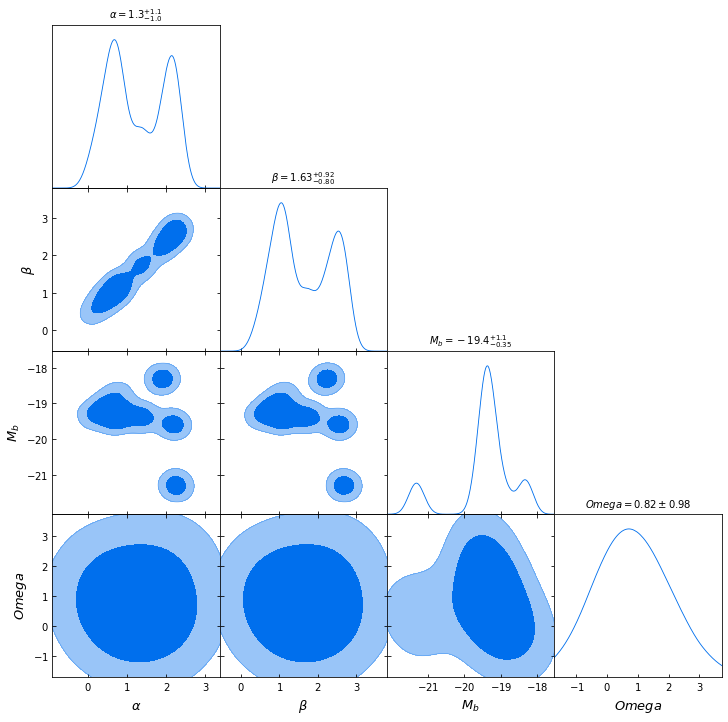

In [22]:
trPlot = plots.get_subplot_plotter(subplot_size=3)
samples = MCSamples(samples = np.array(fullDataSet), labels = ['α', 'β', 'M_b', 'Omega'], names = ['α', 'β', 'M_b', 'Omega'])
trPlot.triangle_plot(samples, filled=True, title_limit=1)

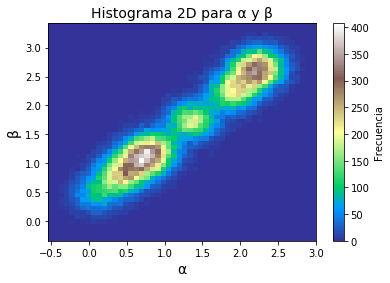

In [23]:
xdots, ydots, zdots = [], [], []

for pair in fullDataSet:
    xdots.append(pair[0])
    ydots.append(pair[1])
    zdots.append(pair[2])
    
plt.hist2d(xdots, ydots, bins = 50, cmap = 'terrain')
plt.colorbar(label = 'Frecuencia')
plt.title('Histograma 2D para α y β', fontsize = 14)
plt.xlabel('α', fontsize = 14)
plt.ylabel('β', fontsize = 14)
plt.show()

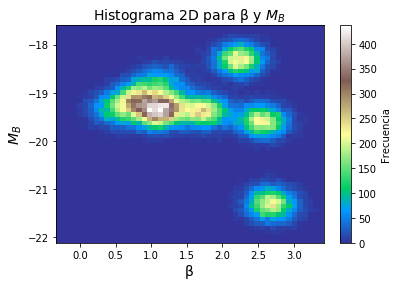

In [24]:
xdots, ydots, zdots = [], [], []

for pair in fullDataSet:
    xdots.append(pair[0])
    ydots.append(pair[1])
    zdots.append(pair[2])
    
plt.hist2d(ydots, zdots, bins = 50, cmap = 'terrain')
plt.colorbar(label = 'Frecuencia')
plt.title('Histograma 2D para β y $M_{B}$', fontsize = 14)
plt.xlabel('β', fontsize = 14)
plt.ylabel('$M_{B}$', fontsize = 14)
plt.show()

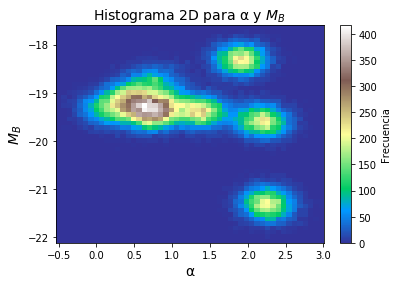

In [25]:
xdots, ydots, zdots = [], [], []

for pair in fullDataSet:
    xdots.append(pair[0])
    ydots.append(pair[1])
    zdots.append(pair[2])
    
plt.hist2d(xdots, zdots, bins = 50, cmap = 'terrain')
plt.colorbar(label = 'Frecuencia')
plt.title('Histograma 2D para α y $M_{B}$', fontsize = 14)
plt.xlabel('α', fontsize = 14)
plt.ylabel('$M_{B}$', fontsize = 14)
plt.show()